In [ ]:
import os

# enable TF32 for tensor cores
os.environ['CUPY_TF32'] = "1"
os.environ['CUPY_ACCELERATORS'] = "cub,cutensor"

import numpy as np

import cupy
from cupy.cuda import cublas

import seaborn as sns
import matplotlib.pyplot as plt

from activations import SiLU, SoftMax
from layers import TransformerBlock, LayerNorm, Convolution, Flatten, MaxPool, Dense, Dropout
from network import Network, CrossEntropy
from transformer_adapters import VitProjector, VitMLPHead, GPTEmbedFront, GPTEmbedBack
from utils import *


# Enable tensor core kernels 
cublas_handle = cupy.cuda.Device().cublas_handle
cublas.setMathMode(cublas_handle, cublas.CUBLAS_TENSOR_OP_MATH)

In [ ]:
def load_batch(batch_path):
    with open(batch_path, 'rb') as f:
        dct = pickle.load(f, encoding='latin1')
    data = dct['data']
    labels = np.array(dct['labels'])
    data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return data, labels


def load_cifar10(root = "datasets/cifar-10-batches-py/"):
    x_train = []
    y_train = []

    for i in range(1, 6):
        data, labels = load_batch(os.path.join(root, f"data_batch_{i}"))
        x_train.append(data)
        y_train.append(labels)

    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)

    x_test, y_test = load_batch(os.path.join(root, "test_batch"))

    return x_train, y_train, x_test, y_test


(x_train, y_train), (x_test, y_test) = load_cifar10()

x_train = (x_train / 255).astype(np.float32)
x_test  = (x_test / 255).astype(np.float32)

In [ ]:
model = Network(
    [
        Convolution((32,32,3), (3,3), 16),
        MaxPool(2,2),
        SiLU(),

        Convolution((15,15,16), (4,4), 32),
        MaxPool(2,2),
        SiLU(),

        Flatten(),
        Dropout(0.25),

        Dense(1152,128),
        SiLU(),
        Dropout(0.25),

        Dense(128, 10),
        SoftMax()
    ]
)

criterion = CrossEntropy(10)

In [ ]:
print("Training:")
model.set_eval(False)
model.train(x_train, y_train, criterion, epochs = 10, learning_rate = .003, batch_size = 128, weight_decay = 0.01)

print("Testing:")
model.set_eval(True)
loss, accuracy = model.evaluate(x_test, y_test, criterion, batch_size = 256)
print(f"Loss: {loss}, Accuracy: {accuracy}")

In [ ]:
# some cave man image aug for ViT
x_train = np.concatenate([x_train, np.flip(x_train, axis = 2)])
x_train = np.concatenate([x_train, np.roll(x_train, 1,  axis = 1),
                                   np.roll(x_train, -1, axis = 1),
                                   np.roll(x_train, 1,  axis = 2),
                                   np.roll(x_train, -1, axis = 2),])

y_train = np.array(y_train)
y_train = np.concatenate([y_train, y_train])
y_train = np.concatenate([y_train, y_train, y_train, y_train, y_train])

shuffle = np.random.permutation(len(x_train))

x_train = x_train[shuffle]
y_train = y_train[shuffle].reshape(-1)

x_test = cupy.array((x_test / 255.0), dtype = np.float32)
y_test = cupy.array(y_test).reshape(-1)

embed_size = 512
num_heads = 8
num_latents = 15
dropout_rate = 0.5

image_size = (32, 32, 3)
patch_size = (4, 4)

model = Network(
    [
        VitProjector(image_size, patch_size, embed_size, num_latents = num_latents),

        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),

        LayerNorm(embed_size),
        VitMLPHead(embed_size, 10),
        SoftMax()
    ]
)

criterion = CrossEntropy(10)

In [ ]:
print("Training:")
model.set_eval(False)
model.train(x_train, y_train, criterion, epochs = 5, learning_rate = .001, batch_size = 128, weight_decay = 0.01)

print("Testing:")
model.set_eval(True)
loss, accuracy = model.evaluate(x_test, y_test, criterion, batch_size = 256)
print(f"Loss: {loss}, Accuracy: {accuracy}")

In [5]:
# Adapted from Andrej Karpathy's GPT Tutorial: https://github.com/karpathy/ng-video-lecture

text = None
with open('shakespeare.txt') as handle:
    text = handle.read()

chars = sorted(list(set(text)))

vocab_size = 64
embed_size = 512
num_heads = 8
context_length = 1024

batch_size = 16
dropout_rate = 0.25

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

tokens = np.array(encode(text), dtype=np.uint8)
arr = []
for i in range(len(tokens) - context_length + 1):
  arr.append(tokens[i:i+context_length])

arr = np.array(arr, dtype=np.uint8)

data = arr[:-1]
labels = arr[1:]

shuffle = np.random.permutation(len(data))

data = data[shuffle]
labels = labels[shuffle]
print(data.shape, data.dtype, labels.shape, labels.dtype)

(1114370, 1024) uint8 (1114370, 1024) uint8


In [ ]:
class GPT:
    def __init__(self):

        self.embedding_size = embed_size
        self.num_heads = num_heads
        self.embedding_table = init_random_tensor(size = (vocab_size, self.embedding_size))
        self.model = Network(
            [
                GPTEmbedFront(self.embedding_table, context_length),

                TransformerBlock(self.embedding_size, context_length, self.num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(self.embedding_size, context_length, self.num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(self.embedding_size, context_length, self.num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(self.embedding_size, context_length, self.num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(self.embedding_size, context_length, self.num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(self.embedding_size, context_length, self.num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(self.embedding_size, context_length, self.num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(self.embedding_size, context_length, self.num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),

                GPTEmbedBack(self.embedding_table),
                SoftMax()
            ],
        )
        self.criterion = CrossEntropy(num_classes = vocab_size)


    def train(self, epochs = 1):

      x = data
      y = labels

      self.model.train(x, y, self.criterion, epochs = epochs, learning_rate = .0003, batch_size = batch_size)

    def generate(self, length, seed = " "):

          print(seed, end = "")

          tokens = cupy.array(encode(seed), dtype = cupy.uint8).reshape((1, len(seed)))

          for i in range(length):

            tokens = tokens[:,max(0, len(tokens[0]) - 256):]

            probs = self.model.predict(tokens)[0, -1]
            out = cupy.random.choice(cupy.arange(0, 64, dtype = cupy.uint8), size = (1,1), p = probs)

            tokens = cupy.concatenate((tokens, out), axis = 1)

            print(itos[int(out[0,0].get())], end = "")

gpt = GPT()


In [ ]:
gpt.model.predict(data[:batch_size])
for layer in gpt.model.layers:
  print("Input Type:", layer.input.dtype, "Layer:", type(layer), "Output Type:", layer.output.dtype)

In [8]:
gpt.train()

100%|██████████| 69649/69649 [3:20:59<00:00,  5.78it/s]

epoch: 1 loss: 808.9559912775828 accuracy: 828.2453260586699 



In [24]:
gpt.model.set_eval(True)
gpt.model.layers[-1].temperature = 0.3
gpt.generate(4096, "PETRUCHIO:")

PETRUCHIO:
Finh be auty unto the grave better hour
A little bear to stay and a labour
Whe all I bear the shall be dishonour'd.

KATHARINA:
The sun thy shame, then let the be thy shame,
I will appeared it so weak and well appear,
The should should say honour'd the must not so,
The market his prophet so he senseless;
Which other house and pale his son the world,
Is the wood go me dead with me for her sighs;
So for that he dreams of the once more smooth,
Than creep this crown and revenge her steps.

BUCKINGHAM:
I'll claim that promise the league of your lives
To most all consons you and your patience,
Your children confession your blood thanks.

GLOUCESTER:
My lord, the mayor and could not be long.

LADY ANNE:
I'll tell yow you hear it would be mew'd these with grounds.

GLOUCESTER:
I cannot tell: the world is grown so bad,
That wrens make prey where eagles dare not perch:
Since every Jack became a gentleman;
And in the crape of life and those stones,
And in the search of the oracles worl

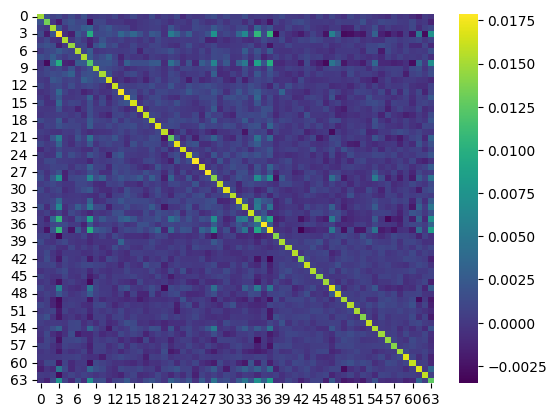

In [26]:
# Visualize token dot product similarities
similarities = (gpt.embedding_table @ gpt.embedding_table.transpose()).get()


similarities /= np.linalg.trace(similarities)

sns.heatmap(similarities, cmap = "viridis")
plt.show()

In [ ]:
import pickle
path = "/content/drive/MyDrive/ai-models/" # colab drive

In [12]:
def save_weights(model, path):

  lst = []

  for layer in model.layers:

    dct = {
        "name": type(layer).__name__,
        "parameters": []
    }

    for parameter in layer.parameters:
      dct["parameters"].append(parameter.get())
    lst.append(dct)

  with open(path, "wb") as handle:
    pickle.dump(lst, handle)


def load_weights(model, path):

  model.zero_grad()

  lst = []

  with open(path, "rb") as handle:
    lst = pickle.load(handle)

  for layer, dct in zip(model.layers, lst):
    for parameter, arr in zip(layer.parameters, dct["parameters"]):
      parameter *= 0
      parameter += cupy.array(arr, dtype = cupy.float32)



In [13]:
save_weights(gpt.model, path + "my_shakespeare_gpt_1024.pkl")

In [ ]:
load_weights(gpt.model, path + "my_shakespeare_gpt_1024.pkl")